## Importing Packages

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.cm import get_cmap

## Data Processing

In [340]:
premier_league = pd.read_csv('data/premier-league.csv')
# championship = pd.read_csv('data/championship.csv')
eredivisie = pd.read_csv('data/eredivisie.csv')
liga_nos = pd.read_csv('data/liga-nos.csv')
bundesliga = pd.read_csv('data/1-bundesliga.csv')
ligue_1 = pd.read_csv('data/ligue-1.csv')
serie_a = pd.read_csv('data/serie-a.csv')
la_liga = pd.read_csv('data/primera-division.csv')
premier_liga = pd.read_csv('data/premier-liga.csv')

In [341]:
transfers = pd.concat([premier_league, eredivisie, liga_nos, bundesliga, ligue_1, serie_a, la_liga, premier_liga])

In [342]:
transfers_in = transfers[(transfers['fee_cleaned']>0)&(transfers['transfer_movement']=='in')&(transfers['year']>2012)&(transfers['club_name']!='Unknown')&(transfers['league_name']!='Unknown')]
transfers_out = transfers[(transfers['fee_cleaned']>0)&(transfers['transfer_movement']=='out')&(transfers['year']>2012)&(transfers['club_name']!='Unknown')&(transfers['league_name']!='Unknown')]

In [343]:
# Define all clubs in the network 
clubs_in = transfers_in[['club_name', 'league_name']]
clubs_out = transfers_out[['club_name', 'league_name']]
clubs = pd.concat([clubs_in, clubs_out]).drop_duplicates()

In [344]:
# Merging transfers_in and transfers_out to filter for transfers where both clubs are in the network
columns = transfers_in.columns
matching_columns = [col for col in columns if col not in ['club_name', 'league_name', 'country', 'club_involved_name', 'transfer_movement']]

# Merge the dfs on the matching columns
merged_df = pd.merge(
    transfers_in,
    transfers_out[matching_columns + ['club_name']],
    on=matching_columns,
    suffixes=('', '_out')
)

merged_df.rename(columns={'club_name_out': 'club_from'}, inplace=True)
# Average transfer fees to get one edge from multiple transfers
final_df = merged_df.groupby(['club_name', 'league_name', 'club_from'])['fee_cleaned'].mean().reset_index()


In [345]:
# Assining numeric values associaed with leagues
league_map = {'Premier League': 0, '1 Bundesliga': 1, 'Ligue 1': 2, 'Serie A': 3, 'Primera Division': 4, 'Eredivisie': 5, 'Liga Nos': 6, 'Premier Liga': 7}

## Creating Network

In [346]:
nodes_list = []
for index, row in clubs.iterrows():
        nodes_list.append((row['club_name'] , {'league': league_map[row['league_name']], 'league_name': row['league_name']}))

In [347]:
edges_list = []
for index, row in final_df.iterrows():
        edges_list.append((row['club_from'], row['club_name'] , int(row['fee_cleaned'])))

In [348]:
# Create network from nodes and edges list
G = nx.DiGraph()
G.clear()
G.add_nodes_from(nodes_list)
G.add_weighted_edges_from(edges_list)

/var/folders/fv/dtyfrg515hz1cwg7pk46whdh0000gn/T/ipykernel_48697/641535135.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', len(unique_leagues_updated))


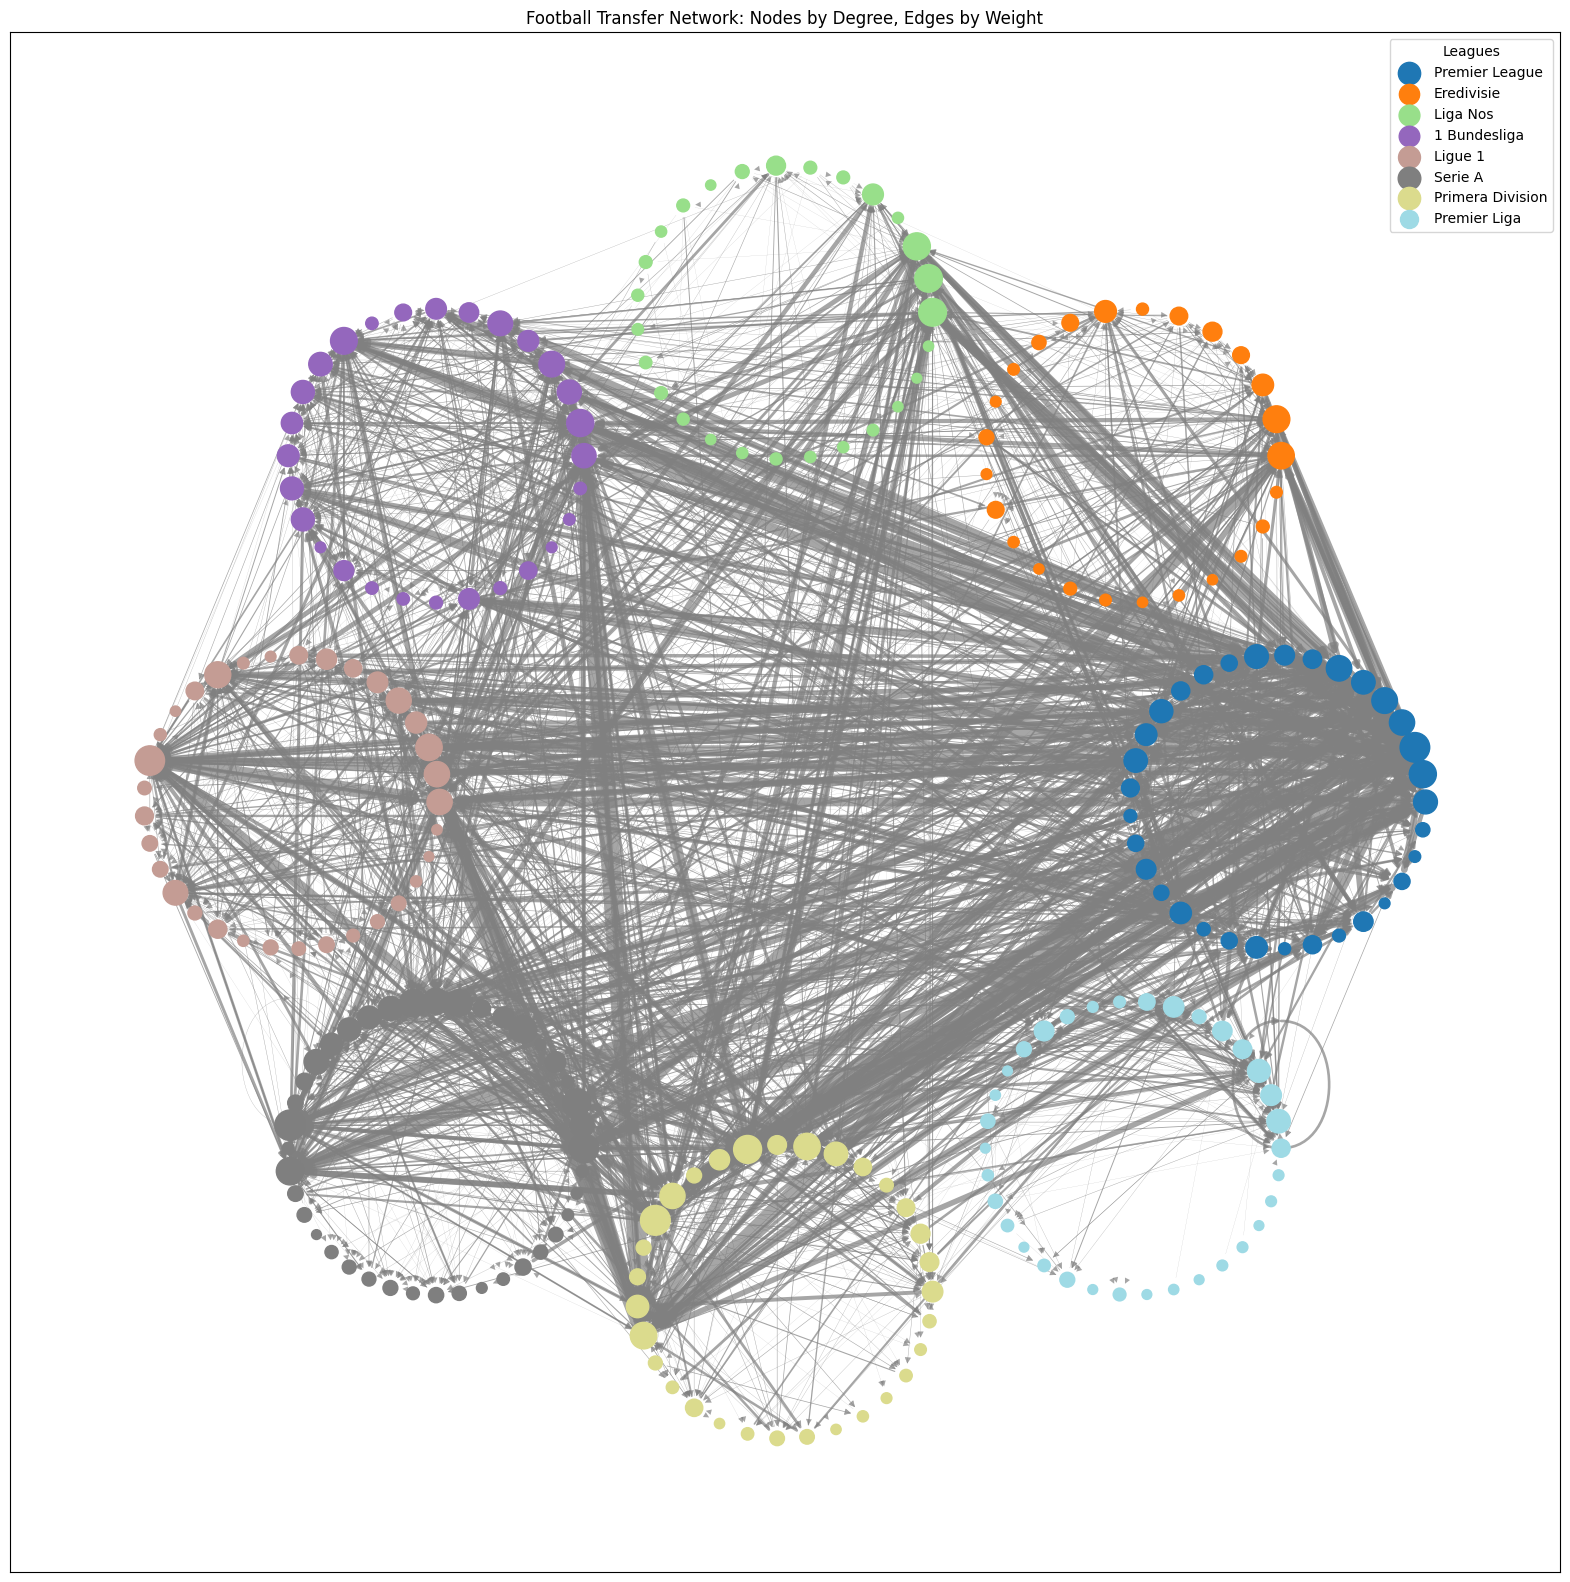

In [415]:
graph_updated = G

# Group nodes by their updated league_name attribute
league_groups_updated = {}
for node in graph_updated.nodes():
    league_name = graph_updated.nodes[node].get('league_name', 'Unknown')
    if league_name not in league_groups_updated:
        league_groups_updated[league_name] = []
    league_groups_updated[league_name].append(node)

# Create distinct colors for each league group
unique_leagues_updated = list(league_groups_updated.keys())
cmap = get_cmap('tab20', len(unique_leagues_updated))
league_colors_updated = {league: cmap(i) for i, league in enumerate(unique_leagues_updated)}

# Number of leagues to arrange in a larger circle
num_leagues_updated = len(league_groups_updated)
radius = 5  # Radius for the large circle of leagues
# Calculate positions for league centers on a large circle
league_centers_updated = {
    league: (
        radius * np.cos(2 * np.pi * i / num_leagues_updated),
        radius * np.sin(2 * np.pi * i / num_leagues_updated),
    )
    for i, league in enumerate(league_groups_updated.keys())
}

# Initialize position dictionary
pos_updated = {}

# Arrange each league's nodes in a smaller circle around its league center
small_circle_radius = 1.5  # Radius for the small circle for each league
for league, center in league_centers_updated.items():
    nodes = league_groups_updated[league]
    angle_step = 2 * np.pi / len(nodes) if nodes else 0
    for j, node in enumerate(nodes):
        angle = j * angle_step
        pos_updated[node] = (
            center[0] + small_circle_radius * np.cos(angle),
            center[1] + small_circle_radius * np.sin(angle),
        )

# Edge weights for visualization
edge_weights_updated = [graph_updated[u][v]['weight'] for u, v in graph_updated.edges()]

# Node sizes by degree (scaled for better visualization)
node_sizes = [50 + 5 * graph_updated.degree(node) for node in graph_updated.nodes()]

# Visualize the graph with updated attributes
plt.figure(figsize=(20, 20))

# Draw nodes, color-coded by league group and sized by degree
for league, nodes in league_groups_updated.items():
    nx.draw_networkx_nodes(
        graph_updated,
        pos_updated,
        nodelist=nodes,
        node_size=[node_sizes[list(graph_updated.nodes).index(node)] for node in nodes],
        node_color=[league_colors_updated[league]],
        label=league,
    )

# Draw edges with thickness proportional to weight
nx.draw_networkx_edges(
    graph_updated,
    pos_updated,
    width=[0.1 * w for w in edge_weights_updated],  # Scaled thickness
    alpha=0.7,
    edge_color='gray',
)

# Add legend for league groups with actual league names
plt.legend(scatterpoints=1, loc="upper right", fontsize=10, title="Leagues")

plt.title("Football Transfer Network: Nodes by Degree, Edges by Weight")
plt.show()


## Computing Network Metrics

In [350]:
# Computing basic network statistics
no_nodes = len(G.nodes())
no_edges = len(G.edges())
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
avg_out_degree = sum(dict(G.out_degree()).values()) / G.number_of_nodes()
max_degree = max(dict(G.degree()).values())

print(f"Number of Nodes: {no_nodes}")
print(f"Number of Links: {no_edges}")
print(f"Average Undirected Degree: {avg_degree}")
print(f"Average Directed Degree: {avg_out_degree}")
print(f"Max Degree: {max_degree}")

Number of Nodes: 251
Number of Links: 2824
Average Undirected Degree: 22.50199203187251
Average Directed Degree: 11.250996015936256
Max Degree: 86


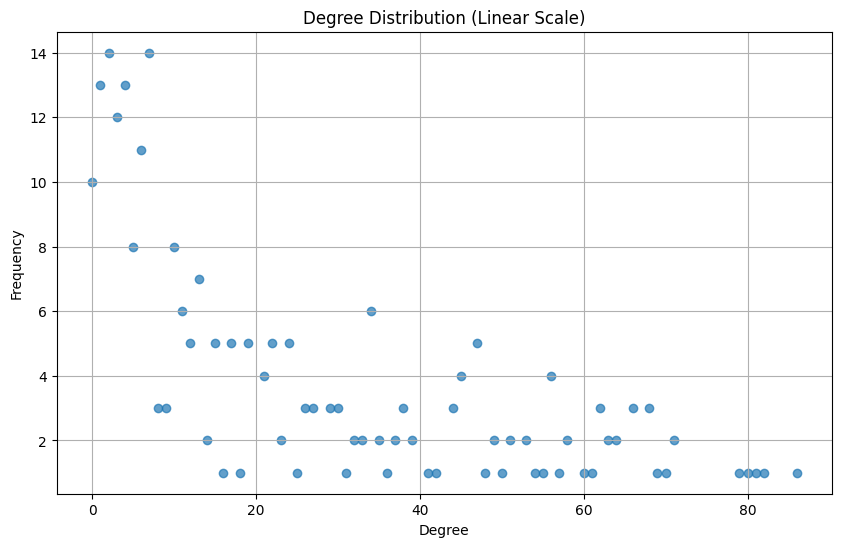

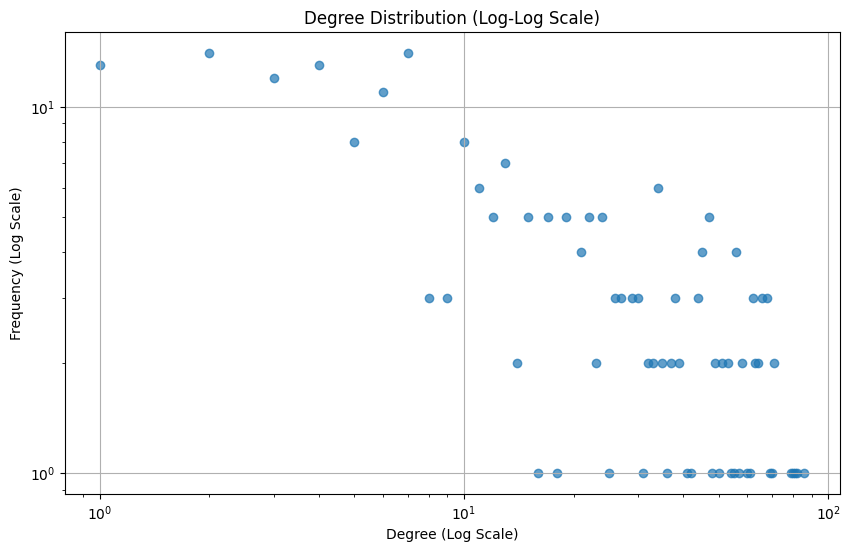

In [354]:
# Extract degree and weighted degree distributions
degrees = [degree for node, degree in graph_updated.degree()]

# Prepare data for plotting
unique_degrees, degree_counts = np.unique(degrees, return_counts=True)

# Plot linear degree distribution
plt.figure(figsize=(10, 6))
plt.scatter(unique_degrees, degree_counts, alpha=0.7)
plt.title("Degree Distribution (Linear Scale)")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# Plot log-log degree distribution
plt.figure(figsize=(10, 6))
plt.scatter(unique_degrees, degree_counts, alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title("Degree Distribution (Log-Log Scale)")
plt.xlabel("Degree (Log Scale)")
plt.ylabel("Frequency (Log Scale)")
plt.grid()
plt.show()


In [355]:
# Calculate global network metrics

# 1. Density
density = nx.density(graph_updated)

# 2. Average Path Length (only for strongly connected components to avoid infinite lengths)
if nx.is_strongly_connected(graph_updated):
    avg_path_length = nx.average_shortest_path_length(graph_updated, weight='weight')
else:
    # Handle disconnected graph by analyzing the largest strongly connected component
    largest_scc = max(nx.strongly_connected_components(graph_updated), key=len)
    subgraph = graph_updated.subgraph(largest_scc)
    avg_path_length = nx.average_shortest_path_length(subgraph, weight='weight')

# 3. Connected Components
# Weakly connected components for directed graphs (ignores edge direction)
num_connected_components = nx.number_weakly_connected_components(graph_updated)
connected_components = list(nx.weakly_connected_components(graph_updated))

# Display results
results = {
    "Density": density,
    "Average Path Length (Largest SCC)": avg_path_length,
    "Number of Connected Components": num_connected_components,
    # "Modularity (Community Detection)": modularity,
}

# Convert connected components to a summary DataFrame
connected_components_df = pd.DataFrame({
    "Component ID": range(len(connected_components)),
    "Size": [len(comp) for comp in connected_components],
})

results


{'Density': 0.04500398406374502,
 'Average Path Length (Largest SCC)': 1.6904199031858607,
 'Number of Connected Components': 11}

In [356]:
# Calculate what these metrics would be for a random graph to compare the distribution
print(f"Random Clustering Coefficient: {avg_degree/(G.number_of_nodes()-1)}")
print(f"Random Graph Average Path Length: {np.log(G.number_of_nodes())/np.log(avg_degree)}")

Random Clustering Coefficient: 0.09000796812749004
Random Graph Average Path Length: 1.7746165610646543


In [357]:
print(f"Giant Component Size: {round(G.number_of_nodes(), 2)}")
print(f"Avg Clustering Coefficient: {round(nx.algorithms.average_clustering(G), 2)}")
print(f"Assortative Coefficient: {round(nx.algorithms.degree_assortativity_coefficient(G), 2)}")

Giant Component Size: 251
Avg Clustering Coefficient: 0.24
Assortative Coefficient: 0.11


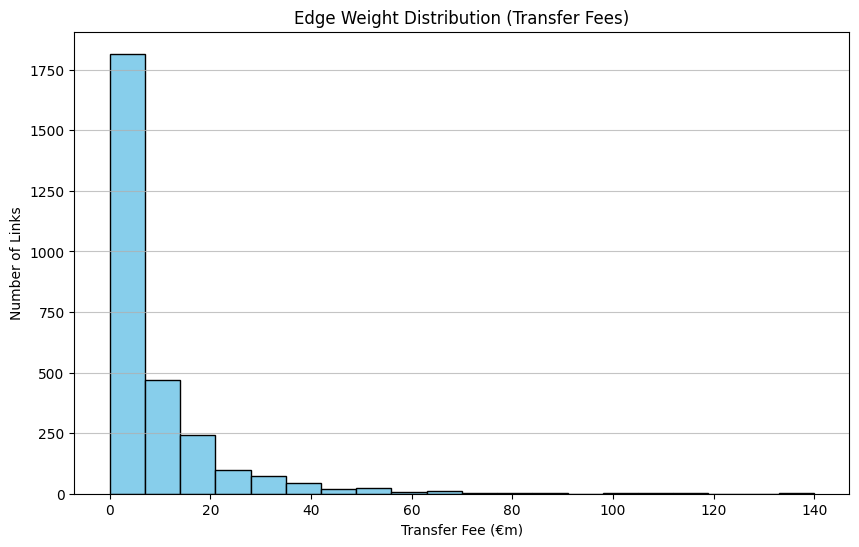

In [358]:
# Extract edge weights (transfer fees) and connections (club pairs)
edge_weights = [graph_updated[u][v]['weight'] for u, v in graph_updated.edges()]
connections = [(u, v) for u, v in graph_updated.edges()]

# Create a DataFrame to analyze edge-level metrics
edges_df = pd.DataFrame({
    "From Club": [u for u, v in connections],
    "To Club": [v for u, v in connections],
    "Transfer Fee": edge_weights
})


# Analyze Edge Weight Distribution
plt.figure(figsize=(10, 6))
plt.hist(edge_weights, bins=20, color='skyblue', edgecolor='black')
plt.title("Edge Weight Distribution (Transfer Fees)")
plt.xlabel("Transfer Fee (€m)")
plt.ylabel("Number of Links")
plt.grid(axis='y', alpha=0.75)
plt.show()

## Assortativity

In [359]:
# Degree assortativity
degree_assortativity = nx.degree_assortativity_coefficient(graph_updated)
print(f"Degree Assortativity Coefficient: {degree_assortativity}")
# Weighted degree assortativity
weighted_degree_assortativity = nx.degree_assortativity_coefficient(graph_updated, weight='weight')
print(f"Weighted Degree Assortativity Coefficient: {weighted_degree_assortativity}")


Degree Assortativity Coefficient: 0.10879527778954357
Weighted Degree Assortativity Coefficient: 0.21152567435233338


### Rich-Club Density

In [360]:
# Calculate weighted degree for each node
weighted_degrees = dict(graph_updated.degree(weight='weight'))

# Set a threshold for "rich" clubs (e.g., top 10% by weighted degree)
threshold = sorted(weighted_degrees.values(), reverse=True)[int(0.1 * len(weighted_degrees))]

# Identify rich clubs
rich_clubs = [node for node, degree in weighted_degrees.items() if degree >= threshold]

# Create subgraph of rich clubs
rich_club_subgraph = graph_updated.subgraph(rich_clubs)

# Calculate the density of connections among rich clubs
total_possible_edges = len(rich_clubs) * (len(rich_clubs) - 1)  # Directed graph
total_edges = sum(1 for u, v, data in rich_club_subgraph.edges(data=True))
rich_club_density = total_edges / total_possible_edges if total_possible_edges > 0 else 0

print(f"Weighted Rich-Club Density: {rich_club_density}")

Weighted Rich-Club Density: 0.48307692307692307


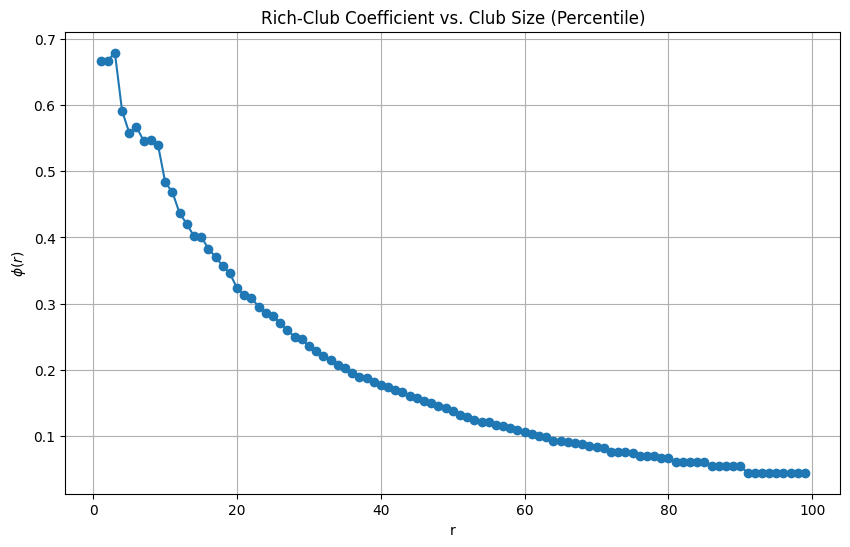

In [361]:
# Prepare data for different rich-club sizes (top X%)
percentiles = range(1, 100)  # Top 1% to 20%
density_values = []

for percentile in percentiles:
    # Set threshold for current percentile
    threshold = sorted(weighted_degrees.values(), reverse=True)[int(percentile / 100 * len(weighted_degrees))]

    # Identify rich clubs for this percentile
    rich_clubs = [node for node, degree in weighted_degrees.items() if degree >= threshold]

    # Create subgraph of rich clubs
    rich_club_subgraph = graph_updated.subgraph(rich_clubs)

    # Calculate edge-based density
    total_possible_edges = len(rich_clubs) * (len(rich_clubs) - 1)  # Directed graph
    total_edges = sum(1 for u, v in rich_club_subgraph.edges())
    density = total_edges / total_possible_edges if total_possible_edges > 0 else 0
    density_values.append(density)

# Plot density as a function of rich-club size
plt.figure(figsize=(10, 6))
plt.plot(percentiles, density_values, marker='o')
plt.title("Rich-Club Coefficient vs. Club Size (Percentile)")
plt.xlabel("r")
plt.ylabel("$\phi(r)$")
plt.grid()
plt.show()


### League Assortativity

In [362]:
league_assortativity = nx.attribute_assortativity_coefficient(graph_updated, 'league_name')
league_assortativity

0.3803960287422522

In [371]:
# Extract leagues and initialize results
league_mapping = {node: graph_updated.nodes[node].get('league_name', 'Unknown') for node in graph_updated.nodes()}
leagues = set(league_mapping.values())

league_assortativity_results = {}

for league in leagues:
    # Create a subgraph for the league
    league_nodes = [node for node, lg in league_mapping.items() if lg == league]
    league_subgraph = graph_updated.subgraph(league_nodes)
    
    # Calculate intra-league assortativity
    intra_edges = sum(1 for u, v in league_subgraph.edges())
    total_edges = sum(
    1 for u, v in graph_updated.edges()
    if league_mapping[u] == league or league_mapping[v] == league
)


    assortativity = intra_edges / total_edges if total_edges > 0 else 0
    
    league_assortativity_results[league] = {
        "Intra-League Edges": intra_edges,
        "Total Edges (Including External)": total_edges,
        "Assortativity (Intra %)": assortativity,
    }

# Convert results to a DataFrame for display
league_assortativity_df = pd.DataFrame.from_dict(league_assortativity_results, orient='index')


In [372]:
league_assortativity_df

,Intra-League Edges,Total Edges (Including External),Assortativity (Intra %)
Eredivisie,90,291,0.309278
Primera Division,154,600,0.256667
Premier League,194,808,0.240099
Premier Liga,123,268,0.458955
Liga Nos,58,302,0.192053
1 Bundesliga,216,632,0.341772
Ligue 1,158,612,0.258170
Serie A,331,811,0.408138


## Centrality

In [400]:
# Calculate metrics
# 1. Weighted Degrees (In-Degree and Out-Degree with Weights)
weighted_in_degree = dict(graph_updated.in_degree(weight='weight'))
weighted_out_degree = dict(graph_updated.out_degree(weight='weight'))

undirected_graph = graph_updated.to_undirected()
betweenness_centrality = nx.betweenness_centrality(undirected_graph)

# 3. PageRank
pagerank = nx.pagerank(graph_updated, weight='weight')

# 4. Clustering Coefficient
clustering_coefficient = nx.clustering(graph_updated, weight='weight')

metrics_df = pd.DataFrame({
    "Club": list(graph_updated.nodes()),
    "Weighted In-Degree": [weighted_in_degree[node] for node in graph_updated.nodes()],
    "Weighted Out-Degree": [weighted_out_degree[node] for node in graph_updated.nodes()],
    "Clustering Coefficient": [clustering_coefficient[node] for node in graph_updated.nodes()],
    "Betweenness Centrality": [betweenness_centrality[node] for node in graph_updated.nodes()],
    "PageRank": [pagerank[node] for node in graph_updated.nodes()]
})


In [401]:
metrics_df.sort_values('Weighted In-Degree', ascending=False).head(10)

,Club,Weighted In-Degree,Weighted Out-Degree,Clustering Coefficient,Betweenness Centrality,PageRank
2,Chelsea FC,1230,445,0.021236,0.014946,0.039271
1,Manchester City,1021,549,0.027744,0.010446,0.037819
199,FC Barcelona,881,532,0.028180,0.005652,0.030404
0,Manchester United,850,283,0.026363,0.005055,0.030069
109,Paris Saint-Germain,843,343,0.031415,0.005477,0.034852
142,Juventus FC,745,506,0.020015,0.010912,0.025863
3,Arsenal FC,698,264,0.019978,0.008909,0.021263
6,Liverpool FC,640,379,0.019294,0.009255,0.023345
194,Real Madrid,627,505,0.028941,0.013624,0.021555
4,Tottenham Hotspur,625,401,0.019601,0.008328,0.019122


In [402]:
metrics_df.sort_values('Weighted Out-Degree', ascending=False).head(10)

,Club,Weighted In-Degree,Weighted Out-Degree,Clustering Coefficient,Betweenness Centrality,PageRank
124,AS Monaco,503,608,0.013358,0.030288,0.014381
82,Borussia Dortmund,366,607,0.015240,0.010484,0.010423
1,Manchester City,1021,549,0.027744,0.010446,0.037819
199,FC Barcelona,881,532,0.028180,0.005652,0.030404
191,Atlético de Madrid,551,526,0.020155,0.015563,0.015625
57,SL Benfica,184,522,0.010770,0.032152,0.005999
142,Juventus FC,745,506,0.020015,0.010912,0.025863
194,Real Madrid,627,505,0.028941,0.013624,0.021555
33,Ajax Amsterdam,180,502,0.011842,0.029949,0.009947
111,Olympique Lyon,217,487,0.011683,0.019192,0.007431


In [405]:
metrics_df.sort_values('Clustering Coefficient', ascending=False).head(10)

,Club,Weighted In-Degree,Weighted Out-Degree,Clustering Coefficient,Betweenness Centrality,PageRank
109,Paris Saint-Germain,843,343,0.031415,0.005477,0.034852
30,Leeds United,243,107,0.031182,0.000387,0.009356
194,Real Madrid,627,505,0.028941,0.013624,0.021555
199,FC Barcelona,881,532,0.028180,0.005652,0.030404
1,Manchester City,1021,549,0.027744,0.010446,0.037819
132,AS Nancy-Lorraine,0,10,0.026858,0.000000,0.000731
0,Manchester United,850,283,0.026363,0.005055,0.030069
193,Athletic Bilbao,99,181,0.025783,0.000321,0.005293
81,Bayern Munich,479,311,0.024881,0.006807,0.014971
5,Everton FC,406,416,0.023664,0.004499,0.019404


In [403]:
metrics_df.sort_values('Betweenness Centrality', ascending=False).head(10)

,Club,Weighted In-Degree,Weighted Out-Degree,Clustering Coefficient,Betweenness Centrality,PageRank
58,Sporting CP,112,361,0.005325,0.039187,0.004608
59,FC Porto,143,451,0.009211,0.036484,0.007068
57,SL Benfica,184,522,0.010770,0.032152,0.005999
124,AS Monaco,503,608,0.013358,0.030288,0.014381
33,Ajax Amsterdam,180,502,0.011842,0.029949,0.009947
214,Spartak Moscow,99,49,0.002206,0.026483,0.004286
34,PSV Eindhoven,77,359,0.006992,0.025841,0.002966
151,Atalanta BC,185,227,0.006853,0.025339,0.006713
216,Zenit St. Petersburg,193,135,0.006511,0.024664,0.010085
113,LOSC Lille,123,385,0.009494,0.023981,0.005101


In [404]:
metrics_df.sort_values('PageRank', ascending=False).head(10)

,Club,Weighted In-Degree,Weighted Out-Degree,Clustering Coefficient,Betweenness Centrality,PageRank
2,Chelsea FC,1230,445,0.021236,0.014946,0.039271
1,Manchester City,1021,549,0.027744,0.010446,0.037819
109,Paris Saint-Germain,843,343,0.031415,0.005477,0.034852
199,FC Barcelona,881,532,0.028180,0.005652,0.030404
0,Manchester United,850,283,0.026363,0.005055,0.030069
142,Juventus FC,745,506,0.020015,0.010912,0.025863
6,Liverpool FC,640,379,0.019294,0.009255,0.023345
194,Real Madrid,627,505,0.028941,0.013624,0.021555
3,Arsenal FC,698,264,0.019978,0.008909,0.021263
5,Everton FC,406,416,0.023664,0.004499,0.019404


In [399]:
# Create a DataFrame where the values are replaced by the clubs ranked by their attributes
ranked_metrics_df = pd.DataFrame({
    "Weighted In-Degree": [club for club, _ in sorted(
        zip(graph_updated.nodes(), [weighted_in_degree[node] for node in graph_updated.nodes()]),
        key=lambda x: x[1], reverse=True)],
    "Weighted Out-Degree": [club for club, _ in sorted(
        zip(graph_updated.nodes(), [weighted_out_degree[node] for node in graph_updated.nodes()]),
        key=lambda x: x[1], reverse=True)],
    "Clustering Coefficient": [club for club, _ in sorted(
        zip(graph_updated.nodes(), [clustering_coefficient[node] for node in graph_updated.nodes()]),
        key=lambda x: x[1], reverse=True)],
    "Betweenness Centrality": [club for club, _ in sorted(
        zip(graph_updated.nodes(), [betweenness_centrality[node] for node in graph_updated.nodes()]),
        key=lambda x: x[1], reverse=True)],
    "PageRank": [club for club, _ in sorted(
        zip(graph_updated.nodes(), [pagerank[node] for node in graph_updated.nodes()]),
        key=lambda x: x[1], reverse=True)]
})

ranked_metrics_df.head(10)


,Weighted In-Degree,Weighted Out-Degree,Clustering Coefficient,Betweenness Centrality,PageRank
0,Chelsea FC,AS Monaco,Paris Saint-Germain,Sporting CP,Chelsea FC
1,Manchester City,Borussia Dortmund,Leeds United,FC Porto,Manchester City
2,FC Barcelona,Manchester City,Real Madrid,SL Benfica,Paris Saint-Germain
3,Manchester United,FC Barcelona,FC Barcelona,AS Monaco,FC Barcelona
4,Paris Saint-Germain,Atlético de Madrid,Manchester City,Ajax Amsterdam,Manchester United
5,Juventus FC,SL Benfica,AS Nancy-Lorraine,Spartak Moscow,Juventus FC
6,Arsenal FC,Juventus FC,Manchester United,PSV Eindhoven,Liverpool FC
7,Liverpool FC,Real Madrid,Athletic Bilbao,Atalanta BC,Real Madrid
8,Real Madrid,Ajax Amsterdam,Bayern Munich,Zenit St. Petersburg,Arsenal FC
9,Tottenham Hotspur,Olympique Lyon,Everton FC,LOSC Lille,Everton FC


## Other Analysis

Quantifying Transfers within leagues

In [407]:
# Group-Level Metrics for Leagues
league_mapping = {node: graph_updated.nodes[node].get('league_name', 'Unknown') for node in graph_updated.nodes()}
inter_league_transfers = {}
intra_league_transfers = {}

# Calculate inter-league and intra-league metrics
for u, v, data in graph_updated.edges(data=True):
    league_u = league_mapping[u]
    league_v = league_mapping[v]
    weight = data.get('weight', 0)
    
    if league_u == league_v:
        # Intra-league transfer
        if league_u not in intra_league_transfers:
            intra_league_transfers[league_u] = {'total_fees': 0, 'volume': 0}
        intra_league_transfers[league_u]['total_fees'] += weight
        intra_league_transfers[league_u]['volume'] += 1
    else:
        # Inter-league transfer
        league_pair = tuple(sorted([league_u, league_v]))
        if league_pair not in inter_league_transfers:
            inter_league_transfers[league_pair] = {'total_fees': 0, 'volume': 0}
        inter_league_transfers[league_pair]['total_fees'] += weight
        inter_league_transfers[league_pair]['volume'] += 1

# Calculate average fees for inter- and intra-league transfers
for league in intra_league_transfers:
    intra_league_transfers[league]['average_fees'] = (
        intra_league_transfers[league]['total_fees'] / intra_league_transfers[league]['volume']
        if intra_league_transfers[league]['volume'] > 0 else 0
    )

for league_pair in inter_league_transfers:
    inter_league_transfers[league_pair]['average_fees'] = (
        inter_league_transfers[league_pair]['total_fees'] / inter_league_transfers[league_pair]['volume']
        if inter_league_transfers[league_pair]['volume'] > 0 else 0
    )

# Convert results to dataframes
intra_league_df = pd.DataFrame.from_dict(intra_league_transfers, orient='index')
inter_league_df = pd.DataFrame.from_dict(inter_league_transfers, orient='index', columns=['total_fees', 'volume', 'average_fees'])


In [408]:
intra_league_df.sort_index(ascending= False)

,total_fees,volume,average_fees
Serie A,1548,331,4.676737
Primera Division,1046,154,6.792208
Premier Liga,275,123,2.235772
Premier League,2963,194,15.273196
Ligue 1,874,158,5.531646
Liga Nos,108,58,1.862069
Eredivisie,122,90,1.355556
1 Bundesliga,944,216,4.370370


In [411]:
# Extract league information for nodes
league_mapping = {node: graph_updated.nodes[node].get('league_name', 'Unknown') for node in graph_updated.nodes()}

league_link_counts = {}
for u, v, data in graph_updated.edges(data=True):
    league_u = league_mapping[u]
    league_v = league_mapping[v]
    if (league_u, league_v) not in league_link_counts:
        league_link_counts[(league_u, league_v)] = 0
    league_link_counts[(league_u, league_v)] += 1

league_links_df = pd.DataFrame([
    {'Source_League': src, 'Target_League': tgt, 'Link_Count': count}
    for (src, tgt), count in league_link_counts.items()
])

league_links_df = league_links_df.sort_values(['Source_League', 'Target_League'], ascending=False)

In [412]:
league_links_df[league_links_df['Source_League']=='Liga Nos']

,Source_League,Target_League,Link_Count
17,Liga Nos,Serie A,20
21,Liga Nos,Primera Division,43
23,Liga Nos,Premier Liga,18
20,Liga Nos,Premier League,34
18,Liga Nos,Ligue 1,39
22,Liga Nos,Liga Nos,58
19,Liga Nos,Eredivisie,5
16,Liga Nos,1 Bundesliga,16


In [414]:
# Looking at Quality of Business interms of profits out-degree minus in-degree
metrics_df['Quality of Deals'] = metrics_df['Weighted Out-Degree']-metrics_df['Weighted In-Degree']
metrics_df.sort_values('Quality of Deals', ascending = False).head(20)

,Club,Weighted In-Degree,Weighted Out-Degree,Clustering Coefficient,Betweenness Centrality,PageRank,Closeness Centrality,Quality of Deals
57,SL Benfica,184,522,0.010770,0.032152,0.005999,0.809468,338
33,Ajax Amsterdam,180,502,0.011842,0.029949,0.009947,0.809468,322
59,FC Porto,143,451,0.009211,0.036484,0.007068,0.423497,308
34,PSV Eindhoven,77,359,0.006992,0.025841,0.002966,0.809468,282
111,Olympique Lyon,217,487,0.011683,0.019192,0.007431,0.290233,270
113,LOSC Lille,123,385,0.009494,0.023981,0.005101,0.429181,262
58,Sporting CP,112,361,0.005325,0.039187,0.004608,0.424434,249
82,Borussia Dortmund,366,607,0.015240,0.010484,0.010423,0.218005,241
148,UC Sampdoria,86,262,0.005835,0.015937,0.003557,0.809468,176
40,AZ Alkmaar,22,186,0.004081,0.013260,0.003452,0.819846,164
